In [4]:
import os
import hdf5plugin
import fabio
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from scipy.signal import find_peaks

*Read files*

In [5]:
im = fabio.open("F:/DTU_task/4.gfrm")
imag = []
for i in range(1,4):
    imag.append(fabio.open(f"F:/DTU_task/{i}.cbf"))

In [6]:
plt.set_cmap('rainbow')

<Figure size 432x288 with 0 Axes>

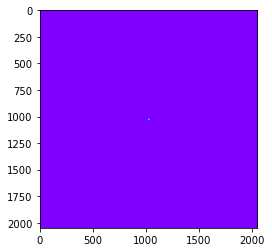

In [7]:
plt.imshow(im.data)

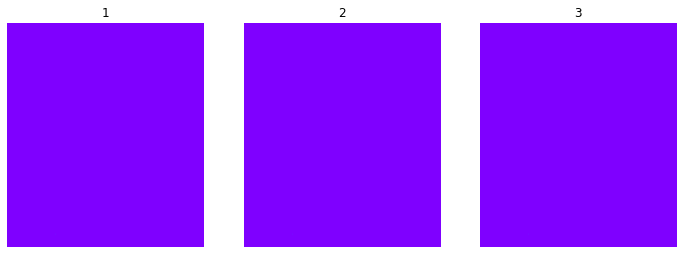

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(imag[i].data)
    ax.set(title=i+1)
    ax.axis('off')
plt.show()

*Data in files 1-3 look like empty. Find sum signals of each detectors*

In [9]:
for i, s in enumerate(imag):
    print(f'Sum signal №{i}', s.data.sum())
print("Sum signal №4",im.data.sum())

Sum signal №0 1538494
Sum signal №1 1523601
Sum signal №2 1565135
Sum signal №4 5668665


*Find shape of flat detector*

In [10]:
for i, s in enumerate(imag):
    print(f'Shape of detector №{i}', s.data.shape)
print('Shape of detector №4', im.data.shape)    

Shape of detector №0 (1679, 1475)
Shape of detector №1 (1679, 1475)
Shape of detector №2 (1679, 1475)
Shape of detector №4 (2048, 2048)


In [11]:
imag[0].header

{
  "_array_data.header_convention": "PILATUS_1.2",
  "_array_data.header_contents": "# Detector: PILATUS 2M - SN01\r\n# 2014-09-24T21:30:58.039\r\n# Pixel_size 172e-6 m x 172e-6 m\r\n# Silicon sensor, thickness 0.000320 m\r\n# Exposure_time 0.0300000 s\r\n# Exposure_period 0.0350000 s\r\n# Tau = 125.0e-09 s\r\n# Count_cutoff 119997 counts\r\n# Threshold_setting: 6839 eV\r\n# Gain_setting: low gain (vrf = -0.300)\r\n# N_excluded_pixels = 0\r\n# Excluded_pixels: (nil)\r\n# Flat_field: (nil)\r\n# Trim_file: p2m_x12sa_E13678_T6839_vrf_m0p30.bin\r\n# Image_path: /dev/shm/zmq/",
  "Content-Type": "application/octet-stream;",
  "conversions": "x-CBF_BYTE_OFFSET",
  "Content-Transfer-Encoding": "BINARY",
  "X-Binary-Size": "2476717",
  "X-Binary-ID": "1",
  "X-Binary-Element-Type": "signed 32-bit integer",
  "X-Binary-Element-Byte-Order": "LITTLE_ENDIAN",
  "Content-MD5": "mwC/wNmlOAeegGFzVlHo0w==",
  "X-Binary-Number-of-Elements": "2476525",
  "X-Binary-Size-Fastest-Dimension": "1475",
  "X-

*Count the number of non-zero pixels*

In [12]:
flatten_array = im.data.flatten()
flatten_array[flatten_array > 0].shape[0] / flatten_array.shape[0] * 100

8.033013343811035

*8% of pixels has signal in file 4*

In [13]:
flatten_array = imag[0].data.flatten()
flatten_array[flatten_array > 0].shape[0] / flatten_array.shape[0] * 100

0.37835273215493487

**Only 0.4% of pixels have a signal in 1-3 files, which means that almost all the information is in a small ROI**

*Since ROIs (region of interest) are too small to observe ones on pictures, find ROI's location plotting graphes. Summarize a signal along axes*

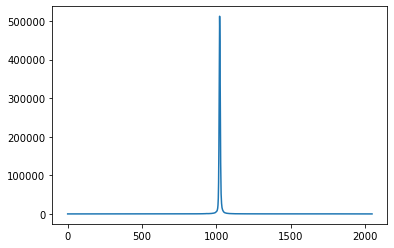

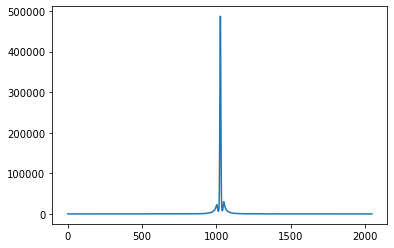

In [14]:
plt.plot(im.data.sum(axis=0))
plt.show()
plt.plot(im.data.sum(axis=1))
plt.show()

*Range of signal amplitude is inappropriate for data visualization. At first, logarithm the data.*

In [15]:
l = np.log10(im.data[:,:] + 1)

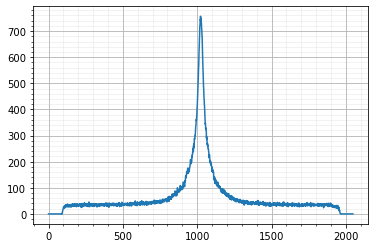

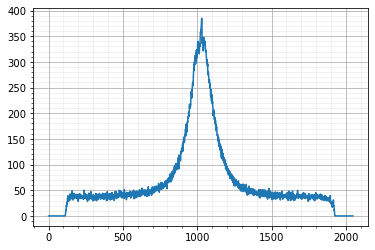

In [16]:
plt.plot(l.sum(axis=0))
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',alpha=.2)
plt.show()
plt.grid()
plt.minorticks_on()
plt.grid(which='minor',alpha=.2)
plt.plot(l.sum(axis=1))

*As far as we can see, ROI is in [800:1250,800:1200] pixels*

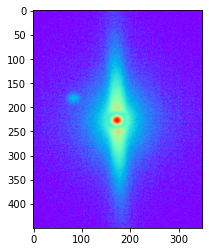

In [17]:
plt.imshow(l[800:1250,850:1200])
plt.show()

*I've loaded data in wrong coordinates. Rotate it*

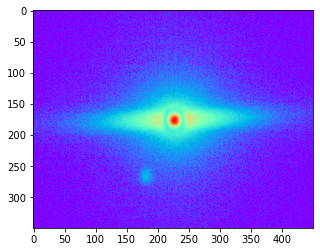

In [18]:
plt.imshow(np.rot90(l[800:1250,850:1200]))
plt.show()

**Question 1: As you can see, the scattering data are clearly anisotropic in reciprocal space. What does that mean in terms of dimensions in real space?**

- Reciprocal space characterizes such properties of a real lattice as the distance between planes, the orientation of the plane, as well as anisotropy. For us, this means that the real sample is anisotropic (which is obvious for fiber). 
- However, I think that a such picture is also the result of the influence of a linear collimator or soller

**Question 2: What can your learn from the orientation of the symmetry axes in the scattering pattern?**
- Finding the axes of symmetry is a key point in the structure calculation of materials, especially crystals. The number of symmetry axes in the scattering image shows the number of the ones in the direct image and their mutual arrangement. Besides it can give a hint about a sample scturcture in whole.
- For our sample, since the anisotropy is in the horizontal plane, the fiber must be positioned vertically.
- It is worth pointing out a spot on the scattering image that may be caused by a defect.  

**Demonstrate quantification of an orientation distribution from one or more of the scattering patterns, or explain how you would do it**

*Let's start with the theory. In figure a, we can observe the propagation of the X-ray beam. The first step is to find the center of the scattering image and the calculation of angles.*

*Convert  pixel number to degree*

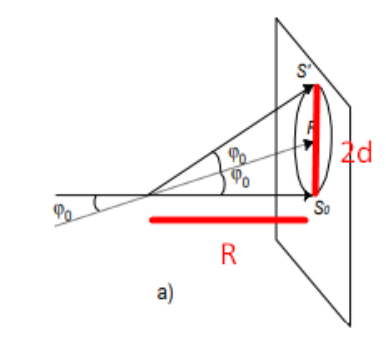

*Since the detector distance R is much larger than d, we can not use the curve detector and calculate the degree as*

$$ \theta \approx  arctan(\frac{d}{R}) \approx arcsin(\frac{d}{R}) \approx \frac{d}{R}$$

*We can calculate d using a size of pixel (s) and a subtraction of pixel numbers -> N(pixel) - N(central pixel)*

$$ d = \Delta n  s$$

$$\theta \approx  arctan(\frac{\Delta n  s}{R})$$

*Calculate the wavelength $$ \lambda = \frac{hc}{E}$$*

*Calculate “length of the scattering vector” or “momentum transfer” $$ q = \frac{4\pi sin(\theta)}{\lambda}$$*

In [19]:
df4 = pd.DataFrame(np.rot90(np.log10(im.data + 1)))

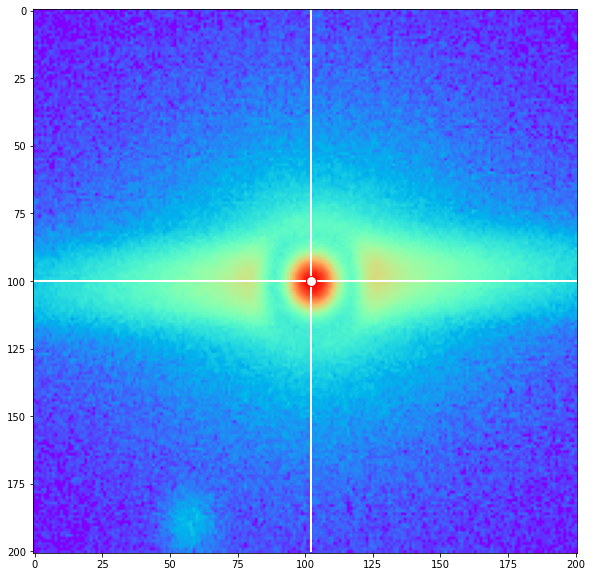

In [20]:
fig, ax = plt.subplots(1,figsize=(10,10))
ax.imshow(df4.loc[924:1124,924:1124])
x1 = [102, 102] #numbers of central pixel
y1 = [0, 200]
x2 = [0, 200]
y2 = [100, 100]
ax.plot(x1, y1, x2, y2, color="white", linewidth=2)
ax.plot(102, 100,marker="o", markersize=10, markeredgecolor="red", markerfacecolor="white")
plt.show()

*Plot two horizontal and vertical graphs, as in the figure above*

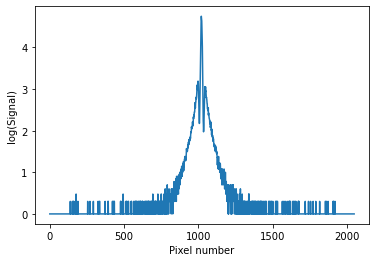

In [21]:
im4_h = pd.Series(np.rot90(df4)[:,1024])
fix, ax = plt.subplots(1,1)
ax.plot(im4_h)
ax.set(xlabel="Pixel number", ylabel="log(Signal)")
plt.show()

*Convert 'the pixel number' to 'the scattering vector'*

In [22]:
im4_h.index = 4 * 3.1459 * np.sin(np.arctan((im4_h.index.to_numpy() - 1024) * 0.068 / 10 ** 3 /  1.1)) / 0.154

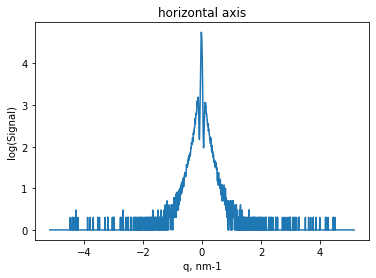

In [23]:
fix, ax = plt.subplots(1,1)
ax.plot(im4_h)
ax.set(xlabel="q, nm-1", ylabel="log(Signal)")
ax.set_title('horizontal axis')
plt.show()

*And study the left part in more detail*

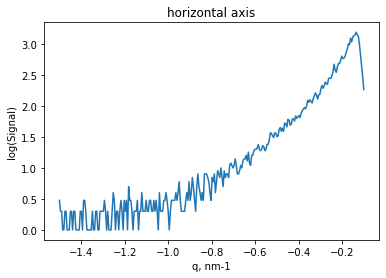

In [24]:
fix, ax = plt.subplots(1,1)
ax.plot(im4_h[-1.5:-0.1])
ax.set(xlabel="q, nm-1", ylabel="log(Signal)")
ax.set_title('horizontal axis')
plt.show()

*Fluctuation in the high part of graph maybe the effect of film thickness on Kiessig fringes or the effect of film roughness and density on Fresnel Reflectivity. Such software as SASview, Xenocs XSACT and other use this data to recover a sample structure, unfortunately I didn't cope and didn't make model of sample.*

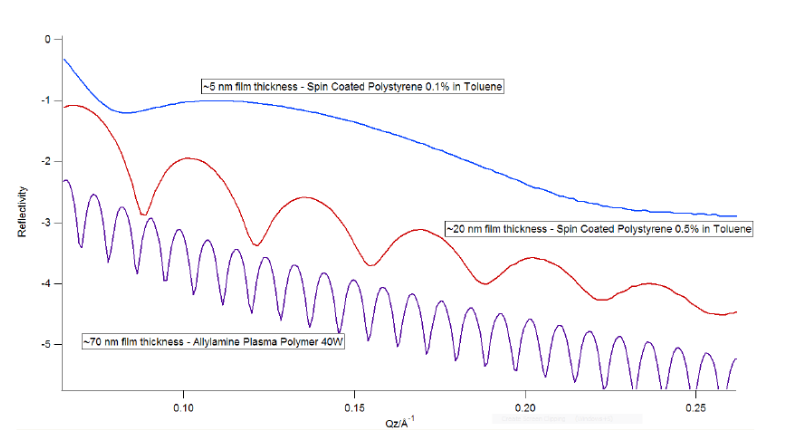
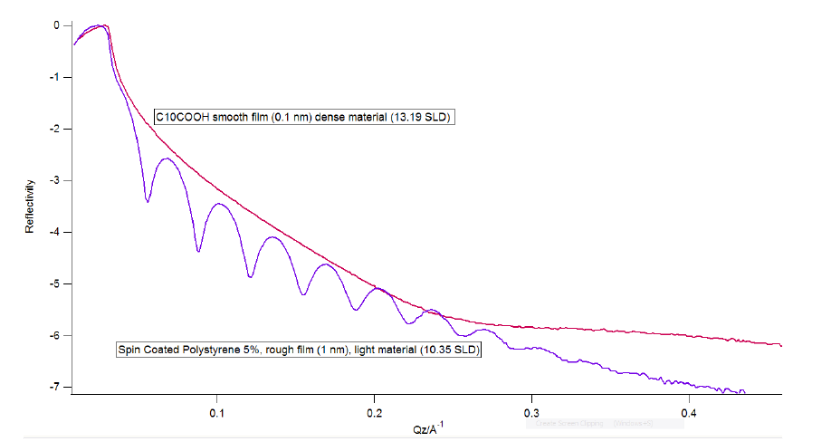

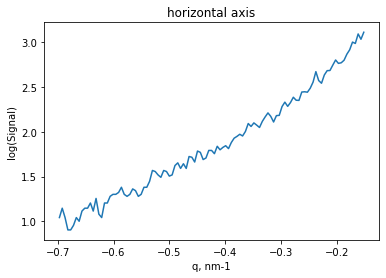

In [25]:
fix, ax = plt.subplots(1,1)
ax.plot(im4_h[-0.7:-.15])
ax.set(xlabel="q, nm-1", ylabel="log(Signal)")
ax.set_title('horizontal axis')
plt.show()

*Peaks on the graph may be Bragg peakes. It allows to **evaluate** distance between planes. The calculations below are an approximation and aim more to show the SAS principle rather than to show an accurate calculation. Since the data must first be processed to remove noise $$d_{bragg} = \frac{4\pi}{q}$$*

In [26]:
peaks, _ = find_peaks(im4_h[-3:-.15])

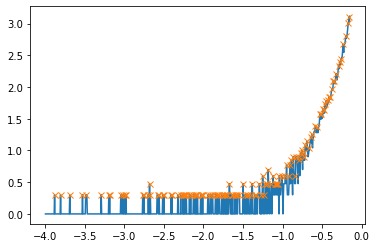

In [51]:
peaks, _ = find_peaks(im4_h[-4:-.15])
plt.plot(im4_h[-4:-.15])
plt.plot(im4_h[-4:-.15].index[list(peaks)], im4_h[-4:-.15][im4_h[-4:-.15].index[peaks]], "x")
plt.show()

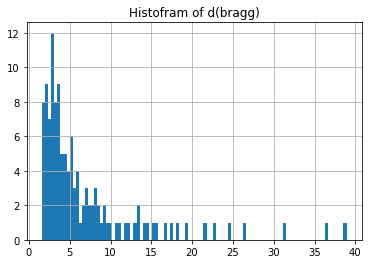

In [55]:
q = im4_h[-4:-.15].index[list(peaks)]
absq = abs(2 * 3.1459 / q)
pd.Series(absq).hist(bins=100)
plt.title('Histofram of d(bragg)')
plt.show()

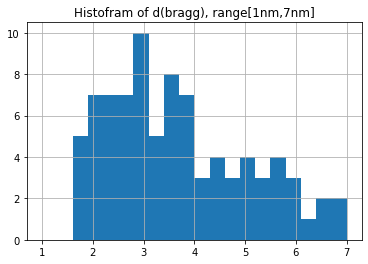

In [56]:
pd.Series(absq).hist(bins=20,range=(1,7))
plt.title('Histofram of d(bragg), range[1nm,7nm]')
plt.show()

*The main peak belongs to 3 nm distance*

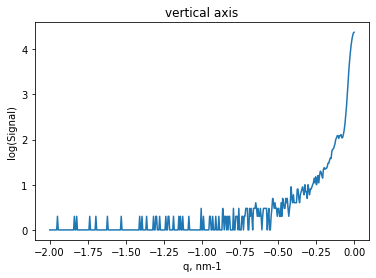

In [57]:
im4_v = pd.Series(np.rot90(df4)[1024,:])
im4_v.index = 4 * 3.1459 * np.sin(np.arctan((im4_v.index.to_numpy() - 1024) * 0.068 / 10 ** 3 /  1.1)) / 0.154
fix, ax = plt.subplots(1,1)
ax.plot(im4_v[-2:0])
ax.set(xlabel="q, nm-1", ylabel="log(Signal)")
ax.set_title('vertical axis')
plt.show()

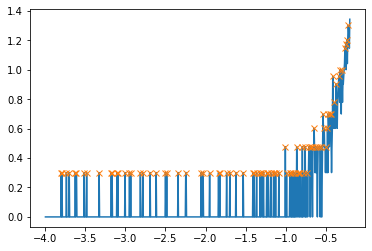

In [58]:
peaks, _ = find_peaks(im4_v[-4:-.2])
plt.plot(im4_v[-4:-.2])
plt.plot(im4_v[-4:-.2].index[list(peaks)], im4_v[-4:-.2][im4_v[-4:-.2].index[peaks]], "x")
plt.show()

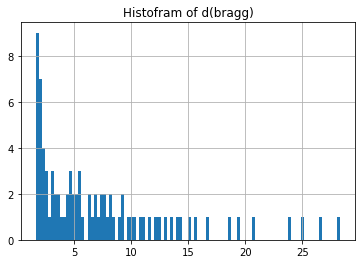

In [59]:
q = im4_v[-4:-.2].index[list(peaks)]
absq = abs(2 * 3.1459 / q)
pd.Series(absq).hist(bins=100)
plt.title('Histofram of d(bragg)')
plt.show()

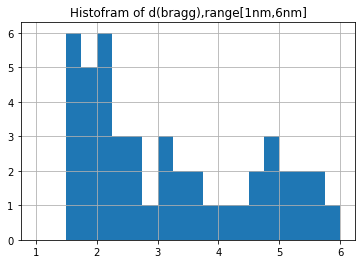

In [60]:
pd.Series(absq).hist(bins=20,range=(1,6))
plt.title('Histofram of d(bragg),range[1nm,6nm]')
plt.show()

**Histograms show differences in the distribution of the distance between the planes on different axes.  In the direction of the horizon d.mod = 3 nm, while in the vertical d.mos = 2 nm and second peak of about 5 nm**

**Question 3: The scattering data represents single projections of the material. What limitations applies then to the quantification of orientation distributions?**

*Technical limitations related to setup*

- incoherence of radiation - we study scattering image only in a narrow cone
- solid spectrum causes secondary peaks and a spectral broadening 
- angular scattering blurs image
- if a detector sensitivity is too low, signal will be lost

*Sample preparation*

- if we prepare a sample unproperly, it causes the effect of film thickness on Kiessig fringes or the effect of film roughness and density on Fresnel Reflectivity and other negative consequences. 


*Study files 1-3*

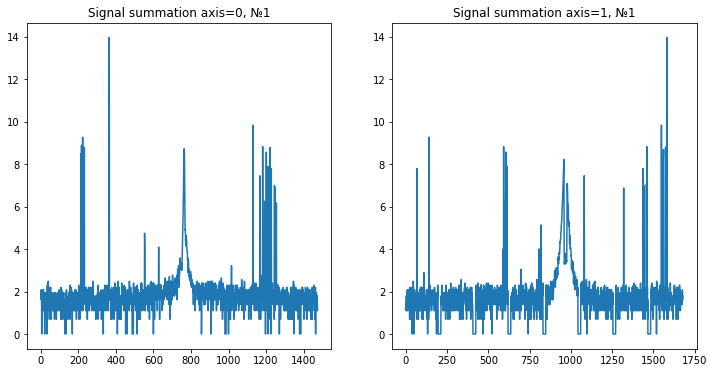

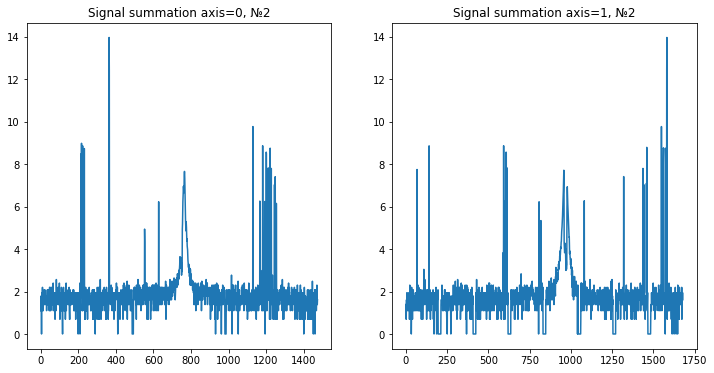

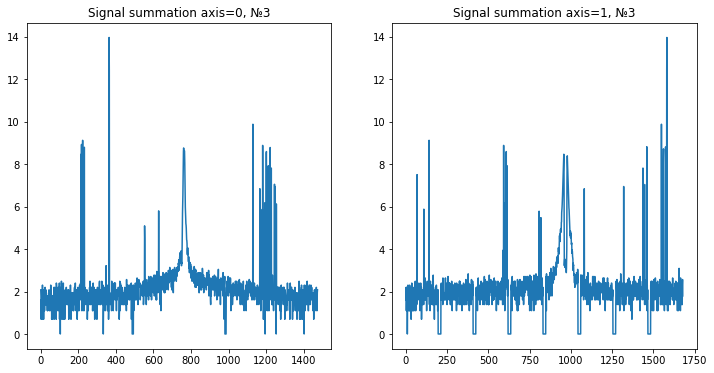

In [34]:
for i in range(3):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].set_title(f'Signal summation axis=0, №{i+1}')
    axes[1].set_title(f'Signal summation axis=1, №{i+1}')
    axes[0].plot(np.log(imag[i].data.sum(axis=0)+1))
    axes[1].plot(np.log(imag[i].data.sum(axis=1)+1))
    plt.show()

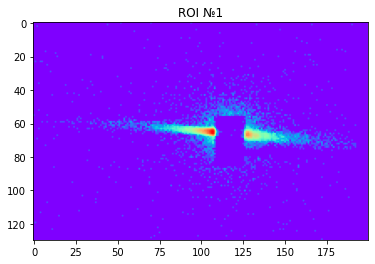

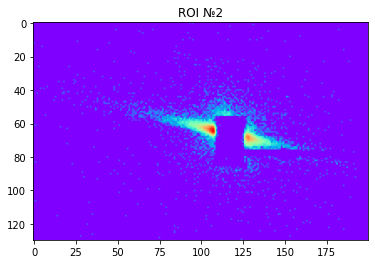

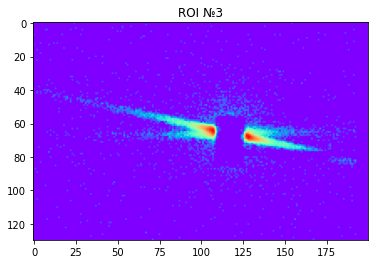

In [35]:
for i in range(3):
    plt.imshow(np.rot90(np.log(imag[i].data + 1)[850:1050,700:830]))
    plt.title(f'ROI №{i+1}')
    plt.show()

*Either the sample has a much higher density or a beamstopper is used*

**Question 4: What is different between frame 1 and 2, and what does the difference signify?**

*If we look at an image below, we can see subtraction between picture 1 and 2. Due to the part of picture is covered,  the center of rotation is hidden to accurately evaluate. Nevetheless, it seems the sample was rotated without shifting in other planes*

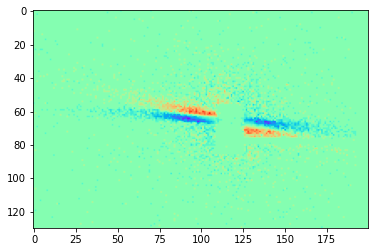

In [36]:
plt.imshow(np.rot90(np.log(imag[1].data + 1)[850:1050,700:830] - np.log(imag[0].data + 1)[850:1050,700:830]))

**Question 5: How is frame 3 different from frames 1 and 2, and how do you interpret what you see?**

*The main difference between figures 3 and 1-2 is the occurrence of new plane on scattering image. It mean that the sample was rotated by the angle to fulfill Bragg's law for other planes. The consequence of this can be seen in the histograms of the d on scattering image (calculation below) as an appearance of new peak near 5 nm. (calculation below)*

*Calculate Bragg peaks for files 1-3. Find numbers of the central pixcel*

In [37]:
df = []
data = []
for i in range(3):
    df.append(pd.DataFrame(np.rot90(np.log10(imag[i].data + 1))))
    data.append(pd.DataFrame(np.rot90(imag[i].data + 1)))

In [38]:
df_sum = df[0] + df[1] + df[2] 

In [39]:
df_sum.sum(axis=0).idxmax()

957

In [40]:
df_sum.sum(axis=1).idxmax()

710

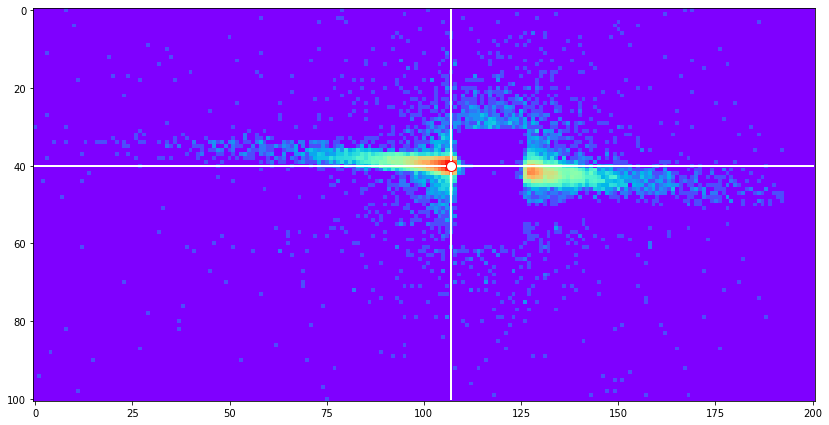

In [41]:
fig, ax = plt.subplots(1,figsize=(14,14))
ax.imshow(df[0].loc[670:770,850:1050])
x1 = [107, 107]
y1 = [0, 100]
x2 = [0, 200]
y2 = [40, 40]
ax.plot(x1, y1, x2, y2, color="white", linewidth=2)
ax.plot(107, 40, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="white")
plt.show()

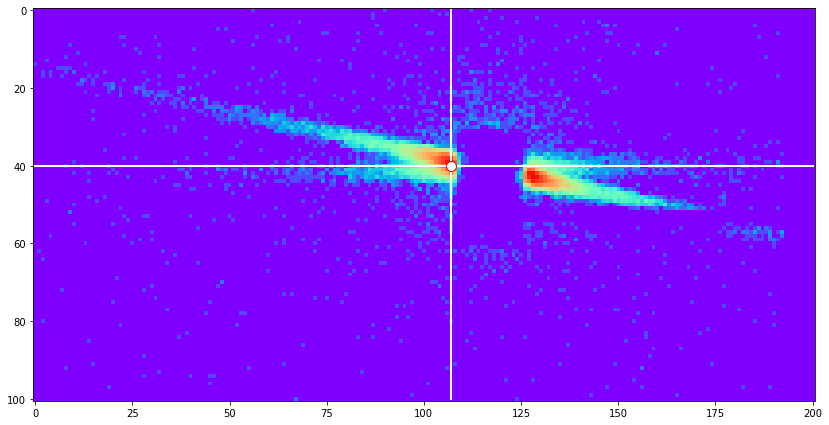

In [42]:
fig, ax = plt.subplots(1,figsize=(14,14))
ax.imshow(df[2].loc[670:770,850:1050])
x1 = [107, 107]
y1 = [0, 100]
x2 = [0, 200]
y2 = [40, 40]
ax.plot(x1, y1, x2, y2, color="white", linewidth=2)
ax.plot(107, 40, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="white")
plt.show()

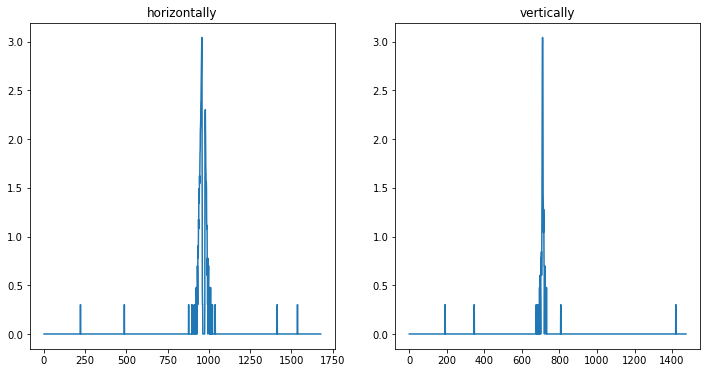

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(df[0].loc[710,:])
axes[1].plot(df[0].loc[:,957])
axes[0].set_title('horizontally')
axes[1].set_title('vertically')
plt.show()

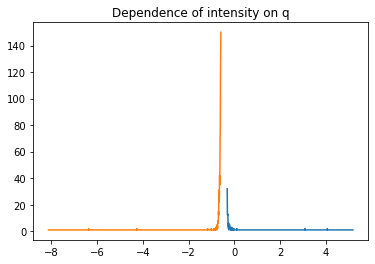

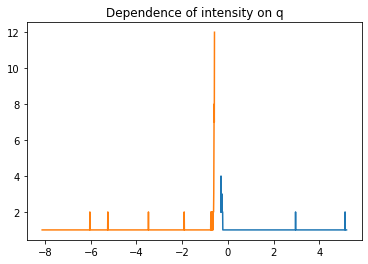

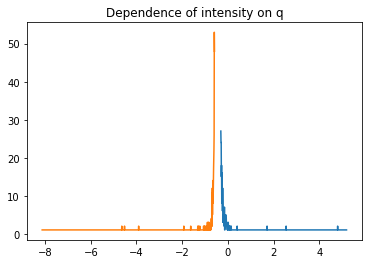

In [71]:
s_right = []
s_left = []
for i in range(3):
    s_right.append(data[i].loc[710,985:])
    s_left.append(data[i].loc[710,:950])
    s_left[i].index = 4 * 3.1459 * np.sin(np.arctan((s_left[i].index.to_numpy() - 1024) * 0.068 / 10 ** 3 /  7)) / 0.0154
    s_right[i].index = 4 * 3.1459 * np.sin(np.arctan((s_right[i].index.to_numpy() - 1024) * 0.068 / 10 ** 3 /  7)) / 0.0154
for i in range(3):   
    plt.plot(s_right[i])
    plt.plot(s_left[i])
    plt.title("Dependence of intensity on q")
    plt.show()

In [46]:
wl = 6.58 / 10 ** 16 * 3 * 10**8 / 12.4 / 1000 * 10 ** 10
print(f'The wavelength = {round(wl,2)} A')

The wavelength = 0.16 A


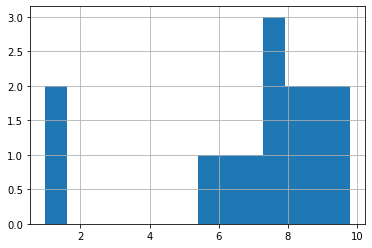

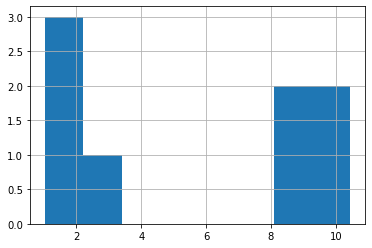

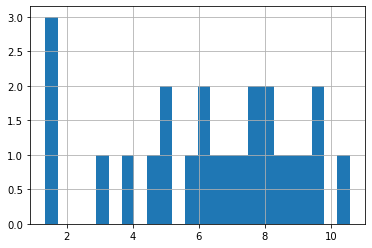

In [78]:
for i in range(3):
    q = s_left[i][-8:-.1].index[list(peaks[i])]
    absq = abs(2 * 3.1459 / q)
    pd.Series(absq).hist(bins=len(absq))
    plt.show()

**Question 6: In what ways are the material represented by frame 4, different from the material represented by frame 1-3?**

*It looks like the beamstopper is used in figures 1-3 (however, perhaps this figure is the result of the sample being smaller than the beam with high density). This means that the materials of sample 1 and sample 4  have different densities. And the main peak in figures 1-3 must be compensated for proper detection. Because of the beam stopper it is impossible to find centre of scattering image using maximum intensity. As result a assessment of average distance for 1-3 files is biased. Fortunately  it stiil allows compare a distribution of d. The second sample has bigger distance between peaks and other distribution. But maybe it is just result of smaller total signal. Other differences are not obvious for me: ways of detection, especially, space resolution vary to compare directly* 

**Conclution:**

*In the first part of the paper, it is shown ways to visualizate SAXS data and prepare their for next study. Most of time  was spent searching python modules to read data. After that data was processed and studied. The graph confirm anisotropy of samples. The main unsolved problem became the quantification of orientation distributions. Internet search didn't help to find necessary libraries or an open soft for this. Recovering a direct space from a scattering image is too difficult a task that I can quickly solve by myself. The way to process lauegramms is next: indexing, determining unit cell parameters and refining the crystal structure. Each of step demands lots of work from noise elimination to comparison with SAS image of real materials.  In general, I tried to show first steps of this process using momentum transfer to find Bragg's distance*